In [1]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 5.6MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 245kB 5.7MB/s 


In [2]:
#!wget https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1 -O erm.zip
!wget https://unirioja-my.sharepoint.com/:u:/g/personal/magarcd_unirioja_es/ERU6UfU2RGREnYNl_KxSpkkB4NP42bHj6siEIWrQ7aWPAQ?download=1 -O erm.zip

--2021-03-05 08:18:45--  https://unirioja-my.sharepoint.com/:u:/g/personal/magarcd_unirioja_es/ERU6UfU2RGREnYNl_KxSpkkB4NP42bHj6siEIWrQ7aWPAQ?download=1
Resolving unirioja-my.sharepoint.com (unirioja-my.sharepoint.com)... 13.107.136.9
Connecting to unirioja-my.sharepoint.com (unirioja-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/magarcd_unirioja_es/Documents/erm.zip?originalPath=aHR0cHM6Ly91bmlyaW9qYS1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9tYWdhcmNkX3VuaXJpb2phX2VzL0VSVTZVZlUyUkdSRW5ZTmxfS3hTcGtrQjROUDQyYkhqNnNpRUlXclE3YVdQQVE_cnRpbWU9MWotWVRLX2YyRWc [following]
--2021-03-05 08:18:47--  https://unirioja-my.sharepoint.com/personal/magarcd_unirioja_es/Documents/erm.zip?originalPath=aHR0cHM6Ly91bmlyaW9qYS1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9tYWdhcmNkX3VuaXJpb2phX2VzL0VSVTZVZlUyUkdSRW5ZTmxfS3hTcGtrQjROUDQyYkhqNnNpRUlXclE3YVdQQVE_cnRpbWU9MWotWVRLX2YyRWc
Reusing existing connection to unirioja-my.sharepo

In [3]:
!unzip erm.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: erm/train/no/anonymized_1873542_fakeB.jpg  
  inflating: erm/train/no/anonymized_887511_fakeB.jpg  
  inflating: erm/train/no/anonymized_1351887_fakeB.jpg  
  inflating: erm/train/no/anonymized_1099051_fakeB.jpg  
  inflating: erm/train/no/anonymized_448602_fakeB.jpg  
  inflating: erm/train/no/anonymized_852019_fakeB.jpg  
  inflating: erm/train/no/anonymized_169973_fakeB.jpg  
  inflating: erm/train/no/anonymized_1241994_fakeB.jpg  
  inflating: erm/train/no/anonymized_1898489_fakeB.jpg  
  inflating: erm/train/no/anonymized_160483_fakeB.jpg  
  inflating: erm/train/no/anonymized_593874_fakeB.jpg  
  inflating: erm/train/no/anonymized_359235_fakeB.jpg  
  inflating: erm/train/no/anonymized_782889_fakeB.jpg  
  inflating: erm/train/no/anonymized_324102_fakeB.jpg  
  inflating: erm/train/no/anonymized_532397_fakeB.jpg  
  inflating: erm/train/no/anonymized_263513_fakeB.jpg  
  inflating: erm/train/no/anonymized_1

In [4]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [5]:
path = Path('erm/')
trainPath = path/'train'
testPath = path/'test'

In [6]:
def getDataBlock(presize=512,size=384):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

In [7]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=16)

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='vit384')
]

In [9]:
import timm
timm.list_models('*vit384*')

[]

In [10]:
import timm

In [11]:
learn = Learner(dls512,timm.models.vision_transformer.vit_base_patch16_384(num_classes=2,pretrained=True),metrics=accuracy,cbs=callbacks)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_384-83fb41ba.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_384-83fb41ba.pth


SuggestedLRs(lr_min=7.585775892948732e-06, lr_steep=1.3182567499825382e-06)

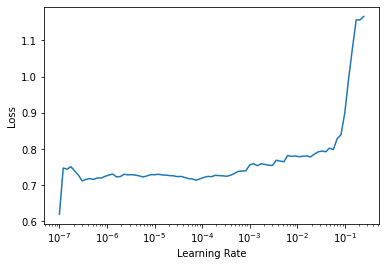

In [12]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.649075,0.644801,0.666157,05:45


Better model found at epoch 0 with valid_loss value: 0.6448012590408325.


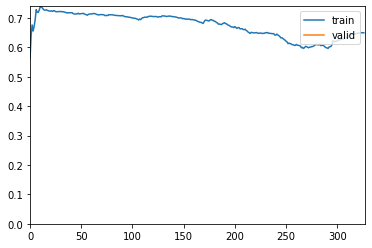

epoch,train_loss,valid_loss,accuracy,time
0,0.427473,0.440285,0.754011,05:44
1,0.394218,0.391045,0.793736,05:44
2,0.395767,0.423045,0.792208,05:44
3,0.368164,0.414090,0.797555,05:45
4,0.360031,0.427287,0.781513,05:44


Better model found at epoch 0 with valid_loss value: 0.44028523564338684.


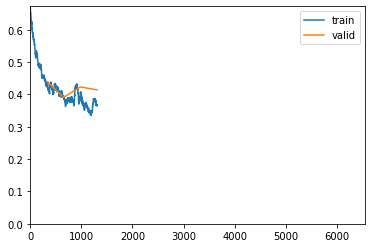

Better model found at epoch 1 with valid_loss value: 0.3910449743270874.
No improvement since epoch 1: early stopping


In [12]:
learn.fine_tune(20,base_lr=1e-4)

In [13]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

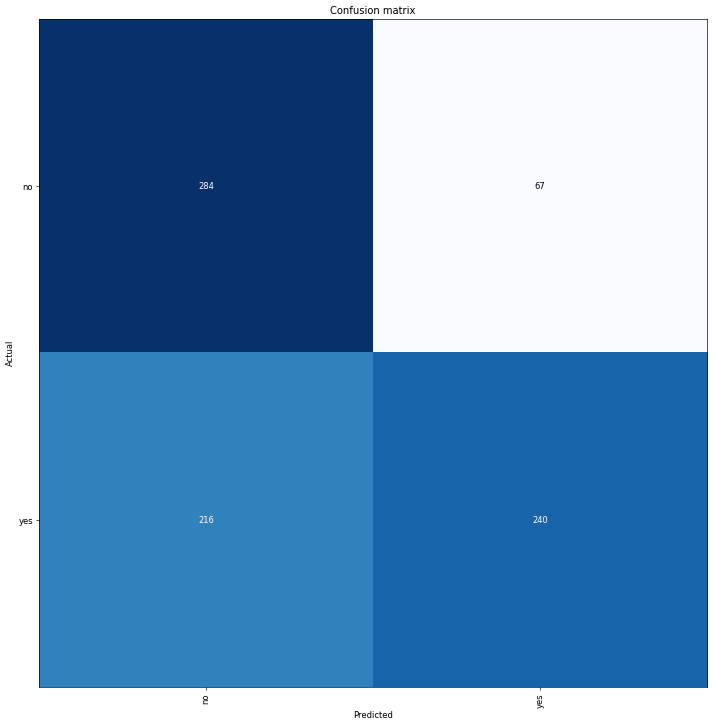

In [14]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [15]:
learn.metrics=[accuracy,Precision(),Recall()]
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6493184566497803.


(#4) [0.6278806924819946,0.6493184566497803,0.7817589576547231,0.5263157894736842]

In [ ]:
learn.export(fname='VIT384.pkl')